# RNN Data Processing Tutorial

This notebook explains how to prepare different types of data for RNNs.

---

## Contents
1. [Part 1: Sequential Data](#sequential)
2. [Part 2: Image Data](#image)
3. [Part 3: Key Concepts](#concepts)

<a id='sequential'></a>
# Part 1: Processing Sequential Data (Text)

## Why Text is Natural for RNNs

Text data is **already sequential** - words and characters follow a specific order:
- "The cat sits" has meaning based on word order
- "sits cat The" is meaningless

### Time Dimension is Built-in

When we read "H-E-L-L-O", we process:
1. Time step 1: H
2. Time step 2: E
3. Time step 3: L
4. Time step 4: L
5. Time step 5: O

The RNN naturally follows this flow.

## Processing Steps for Text

### Step 1: Tokenization

Break text into units (characters or words):
```
"Hello World" → ['H', 'e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l', 'd']
```
or
```
"Hello World" → ['Hello', 'World']
```

### Step 2: Build Vocabulary

Create a mapping from tokens to numbers:
```
{'H': 0, 'e': 1, 'l': 2, 'o': 3, ' ': 4, 'W': 5, 'r': 6, 'd': 7}
```

### Step 3: Convert to Indices

```
"Hello" → [0, 1, 2, 2, 3]
```

### Step 4: One-Hot Encoding (Optional)

Each index becomes a vector where only one position is 1:
```
'H' (index 0) → [1, 0, 0, 0, 0, 0, 0, 0]
'e' (index 1) → [0, 1, 0, 0, 0, 0, 0, 0]
'l' (index 2) → [0, 0, 1, 0, 0, 0, 0, 0]
```

Or use **embedding layers** to learn dense representations.

## Final Shape for RNN

**For character-level (manual RNN)**:
```
Shape: (sequence_length, batch_size, vocab_size)
Example: (5, 1, 58) for "Hello" with 58 possible characters
```

**For word-level (built-in RNN with embeddings)**:
```
Shape: (batch_size, sequence_length, embedding_dim)
Example: (32, 20, 128) for 32 sentences, max 20 words, 128-dim embeddings
```

In [1]:
import torch
import torch.nn as nn
import string

# Simple example: Character-level encoding
allowed_chars = string.ascii_letters + " .,;'"
vocab_size = len(allowed_chars)

def char_to_index(char):
    return allowed_chars.find(char)

def text_to_tensor(text):
    """Convert text to one-hot encoded tensor"""
    tensor = torch.zeros(len(text), 1, vocab_size)
    for i, char in enumerate(text):
        idx = char_to_index(char)
        if idx >= 0:
            tensor[i][0][idx] = 1
    return tensor

# Test
text = "Hello"
tensor = text_to_tensor(text)
print(f"Text: '{text}'")
print(f"Tensor shape: {tensor.shape}")  # (5, 1, vocab_size)
print(f"Format: (seq_len={len(text)}, batch=1, vocab={vocab_size})")

Text: 'Hello'
Tensor shape: torch.Size([5, 1, 57])
Format: (seq_len=5, batch=1, vocab=57)


---

<a id='image'></a>
# Part 2: Processing Image Data

## The Challenge

Images are **NOT naturally sequential**:
- They are 2D grids: Height × Width × Channels
- No inherent "time" dimension
- Pixels can be read in any order (theoretically)

**Question**: How do we make images sequential?

## Solution: Row-by-Row Processing

We artificially create a sequence by treating **each row as a time step**.

### Why Rows?

1. **Natural reading order**: We read top-to-bottom
2. **Spatial coherence**: Adjacent rows contain related visual information
3. **Simple implementation**: Easy to reshape tensors

### The Transformation Process

For CIFAR-10 images (3×32×32):

**Original Image Structure**:
```
Shape: (3, 32, 32)
- 3 color channels (Red, Green, Blue)
- 32 rows
- 32 columns per row
```

**Step 1: Permute - Group RGB Values**
```
image.permute(1, 2, 0)  → Shape: (32, 32, 3)
```

**Why?** 
- BEFORE: Channels separated → Red[32×32], Green[32×32], Blue[32×32]
- AFTER: RGB grouped per pixel → Each pixel has [R, G, B] together

**Step 2: Reshape - Convert Rows to Time Steps**
```
image.reshape(32, 96)  → Shape: (32, 96)
```

**Why?**
- 32 rows → 32 time steps
- Each row has 32 pixels × 3 colors = 96 features

## Visual Understanding

Think of an image like a book:
- **Each row** = One line of text
- **32 rows** = 32 lines
- **RNN reads** from line 1 to line 32 (top to bottom)
- **Each line** contains 96 values (32 pixels × 3 colors)

## Final Shape for RNN

**Single image**:
```
(32, 96) → 32 time steps, 96 features per step
```

**Batch of images**:
```
(batch_size, 32, 96)
Example: (64, 32, 96) for 64 images
```

In [2]:
import torch
from torchvision import datasets, transforms

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
image, label = dataset[0]

print("Original image:")
print(f"  Shape: {image.shape}")  # (3, 32, 32)
print(f"  Format: (channels, height, width)")

# Transform for RNN
image_permuted = image.permute(1, 2, 0)  # (32, 32, 3)
image_sequence = image_permuted.reshape(32, 96)  # (32, 96)

print("\nAfter transformation:")
print(f"  Shape: {image_sequence.shape}")  # (32, 96)
print(f"  Format: (time_steps, features)")
print(f"  Ready for RNN!")

Original image:
  Shape: torch.Size([3, 32, 32])
  Format: (channels, height, width)

After transformation:
  Shape: torch.Size([32, 96])
  Format: (time_steps, features)
  Ready for RNN!


## Use Cases for Image RNNs

### 1. Image Classification
- Process image row-by-row
- Use final hidden state for classification
- Example: CIFAR-10 classification

### 2. Image Captioning
- **Encoder**: CNN extracts features
- **Decoder**: RNN generates caption
- Image features become initial hidden state

```
Image → CNN → Features → RNN → ["A", "cat", "sitting", "on", "mat"]
```

### 3. Video Processing
- **Frames** = Time steps
- Each frame can be processed by CNN first
- RNN captures temporal dynamics

```
Frame 1 → CNN → Features → ┐
Frame 2 → CNN → Features → ├→ RNN → Action classification
Frame 3 → CNN → Features → ┘
```

---

<a id='concepts'></a>
# Part 3: Key Concepts

## Concept 1: Sequence Length

**Text**: Variable length (names have 2-15 characters)
- Solution: Padding with special tokens
- Or: Process one at a time

**Images**: Fixed length (always 32 rows for CIFAR-10)
- No padding needed
- All images same size after transformation

## Concept 2: Feature Dimension

**Text**: 
- Vocabulary size (e.g., 58 characters)
- Or embedding dimension (e.g., 128)

**Images**:
- Width × Channels (e.g., 32 pixels × 3 colors = 96)

## Concept 3: Batch Processing

**Text**:
```
(batch_size, max_seq_len, features)
Example: (32, 20, 128) = 32 sentences, max 20 words, 128-dim embeddings
```

**Images**:
```
(batch_size, num_rows, row_features)
Example: (64, 32, 96) = 64 images, 32 rows, 96 features per row
```

## Concept 4: Why Permute Before Reshape?

**Without permute** (wrong):
```
image.reshape(32, 96)
```
- Mixes values from different channels randomly
- Row 0 gets only Red channel values
- Row 1 gets only Green channel values
- Loses pixel structure!

**With permute** (correct):
```
image.permute(1, 2, 0).reshape(32, 96)
```
- Groups R, G, B for each pixel
- Row 0 gets [R₀,G₀,B₀, R₁,G₁,B₁, ..., R₃₁,G₃₁,B₃₁]
- Preserves pixel structure!

## Summary Table

| Aspect | Sequential Data (Text) | Non-Sequential (Images) |
|--------|----------------------|------------------------|
| **Natural order** | Yes | No (artificial) |
| **Time dimension** | Built-in | Created (rows) |
| **Preprocessing** | Tokenization → Encoding | Permute → Reshape |
| **Sequence length** | Variable | Fixed |
| **Features** | Vocab size or embeddings | Width × Channels |
| **Example shape** | `(batch, seq_len, vocab)` | `(batch, rows, width×3)` |

## Best Practices

### For Text:
1. Use embeddings instead of one-hot (more efficient)
2. Handle variable lengths with padding or packing
3. Consider byte-pair encoding for large vocabularies

### For Images:
1. Always permute before reshape
2. Normalize pixel values
3. Consider CNN + RNN hybrid for better results
4. For video, process frames with CNN first

### General:
1. Always verify shapes before passing to RNN
2. Use batch_first=True for clearer code
3. Watch for memory usage with long sequences
4. Consider LSTM/GRU for longer sequences

{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# RNN Data Processing Tutorial\n",
    "\n",
    "Understanding how to prepare different types of data for Recurrent Neural Networks.\n",
    "\n",
    "---\n",
    "\n",
    "## Contents\n",
    "1. [Part 1: Sequential Data (Text)](#text)\n",
    "2. [Part 2: Non-Sequential Data (Images)](#images)\n",
    "3. [Part 3: Practical Examples](#examples)"
   ]
  },

<a id='intro'></a>
# Part 1: What Do RNNs Need?

## The RNN Input Format

RNNs expect data in **sequence format**:
```
Shape: (batch_size, sequence_length, features)
```

Where:
- **batch_size**: Number of examples processed together
- **sequence_length**: Number of time steps in the sequence
- **features**: Number of values at each time step

### Example:
- Processing 64 images
- Each image has 32 rows (time steps)
- Each row has 96 features
- Shape: `(64, 32, 96)`

In [3]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import string
import unicodedata

print("Libraries imported successfully!")

Libraries imported successfully!


---

<a id='text'></a>
# Part 2: Text Data - Already Sequential

## Why Text Is Easy for RNNs

Text is **naturally sequential**:
- Words in a sentence come one after another
- Characters in a word follow a specific order
- Time flows naturally: Letter 1 → Letter 2 → Letter 3 → ...

**No reshaping needed!** We just convert characters to numbers.

## One-Hot Encoding for Text

Convert each character to a unique vector where only one position is 1, rest are 0.

In [4]:
# Define vocabulary
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

print(f"Vocabulary size: {n_letters} characters")
print(f"Characters: {allowed_characters}")

def letterToIndex(letter):
    """Get the index of a letter in our vocabulary"""
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    return allowed_characters.find(letter)

def lineToTensor(line):
    """Convert a string to a tensor of one-hot vectors"""
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor

# Example
name = "Albert"
tensor = lineToTensor(name)
print(f"\nName: '{name}'")
print(f"Tensor shape: {tensor.shape}")
print(f"Format: (sequence_length, batch_size, features) = ({len(name)}, 1, {n_letters})")

Vocabulary size: 58 characters
Characters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'_

Name: 'Albert'
Tensor shape: torch.Size([6, 1, 58])
Format: (sequence_length, batch_size, features) = (6, 1, 58)


In [5]:
# Visualize one-hot encoding
print("="*70)
print("ONE-HOT ENCODING DEMONSTRATION")
print("="*70)

test_word = "Hi"
tensor = lineToTensor(test_word)

for i, letter in enumerate(test_word):
    idx = letterToIndex(letter)
    print(f"\nCharacter '{letter}' (position {i}):")
    print(f"  Index in vocabulary: {idx}")
    print(f"  One-hot vector shape: {tensor[i].shape}")
    
    # Show first 10 values
    vec = tensor[i][0]
    print(f"  First 10 values: {vec[:10].tolist()}")
    print(f"  Value at index {idx}: {vec[idx].item()} ← This is the '1'")

print("\n" + "="*70)
print("KEY POINT: Each character gets a unique position set to 1")
print("="*70)

ONE-HOT ENCODING DEMONSTRATION

Character 'H' (position 0):
  Index in vocabulary: 33
  One-hot vector shape: torch.Size([1, 58])
  First 10 values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  Value at index 33: 1.0 ← This is the '1'

Character 'i' (position 1):
  Index in vocabulary: 8
  One-hot vector shape: torch.Size([1, 58])
  First 10 values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
  Value at index 8: 1.0 ← This is the '1'

KEY POINT: Each character gets a unique position set to 1


### Text Data Summary

| Aspect | Details |
|--------|--------|
| **Original format** | String: "Albert" |
| **After encoding** | Tensor: `(6, 1, 58)` |
| **Sequence length** | 6 characters |
| **Features** | 58 (vocabulary size) |
| **Preprocessing needed** | ✅ One-hot encoding only |
| **Reshaping needed** | ❌ No - already sequential! |

---

<a id='images'></a>
# Part 3: Image Data - Converting Grids to Sequences

## The Challenge

Images are **2D grids**, not sequences:
- Height × Width × Channels
- No natural time dimension
- Must artificially create a sequence

**Solution**: Treat each row as a time step!

In [6]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)

print(f"Dataset loaded: {len(train_dataset)} images")
print(f"Image shape: {train_dataset[0][0].shape}")

Dataset loaded: 50000 images
Image shape: torch.Size([3, 32, 32])


## Step-by-Step Transformation

### The Process:
1. **Original**: `(3, 32, 32)` - Channels × Height × Width
2. **Permute**: `(32, 32, 3)` - Height × Width × Channels
3. **Reshape**: `(32, 96)` - Sequence_length × Features

Let's see this in action!

In [7]:
# Get a sample image
sample_image, sample_label = train_dataset[0]

print("="*80)
print("IMAGE TO SEQUENCE TRANSFORMATION")
print("="*80)

print(f"\n📷 ORIGINAL IMAGE:")
print(f"   Shape: {sample_image.shape}")
print(f"   Format: (channels, height, width) = (3, 32, 32)")
print(f"   Meaning: 3 color channels (R, G, B), each is 32×32")

print(f"\n   Channel 0 (Red):   {sample_image[0].shape}")
print(f"   Channel 1 (Green): {sample_image[1].shape}")
print(f"   Channel 2 (Blue):  {sample_image[2].shape}")
print(f"   ☝ Channels are SEPARATE matrices")

print("\n" + "─"*80)
print("🔄 STEP 1: PERMUTE")
print("─"*80)

permuted_image = sample_image.permute(1, 2, 0)
print(f"   Command: image.permute(1, 2, 0)")
print(f"   New shape: {permuted_image.shape}")
print(f"   Format: (height, width, channels) = (32, 32, 3)")
print(f"   Meaning: Now each PIXEL has its RGB values together")

print(f"\n   Pixel [0,0]: {permuted_image[0, 0, :]} ← [R, G, B] for first pixel")
print(f"   Pixel [0,1]: {permuted_image[0, 1, :]} ← [R, G, B] for second pixel")
print(f"   ☝ RGB values are NOW TOGETHER for each pixel")

print("\n" + "─"*80)
print("🔄 STEP 2: RESHAPE")
print("─"*80)

sequence_image = permuted_image.reshape(32, 96)
print(f"   Command: permuted.reshape(32, 96)")
print(f"   New shape: {sequence_image.shape}")
print(f"   Format: (sequence_length, features) = (32, 96)")
print(f"   Meaning: 32 rows (time steps), 96 features per row")

print(f"\n   Time step 0 (Row 0): {sequence_image[0].shape}")
print(f"   Time step 1 (Row 1): {sequence_image[1].shape}")
print(f"   ...")
print(f"   Time step 31 (Row 31): {sequence_image[31].shape}")
print(f"   ☝ Each row has 32 pixels × 3 colors = 96 features")

print("\n" + "="*80)
print("✅ FINAL RESULT")
print("="*80)
print(f"Original: (3, 32, 32) → Grid format")
print(f"Final:    (32, 96)    → Sequence format")
print(f"RNN will process this image from top to bottom, row by row!")
print("="*80)

IMAGE TO SEQUENCE TRANSFORMATION

📷 ORIGINAL IMAGE:
   Shape: torch.Size([3, 32, 32])
   Format: (channels, height, width) = (3, 32, 32)
   Meaning: 3 color channels (R, G, B), each is 32×32

   Channel 0 (Red):   torch.Size([32, 32])
   Channel 1 (Green): torch.Size([32, 32])
   Channel 2 (Blue):  torch.Size([32, 32])
   ☝ Channels are SEPARATE matrices

────────────────────────────────────────────────────────────────────────────────
🔄 STEP 1: PERMUTE
────────────────────────────────────────────────────────────────────────────────
   Command: image.permute(1, 2, 0)
   New shape: torch.Size([32, 32, 3])
   Format: (height, width, channels) = (32, 32, 3)
   Meaning: Now each PIXEL has its RGB values together

   Pixel [0,0]: tensor([-0.5373, -0.5137, -0.5059]) ← [R, G, B] for first pixel
   Pixel [0,1]: tensor([-0.6627, -0.6392, -0.6471]) ← [R, G, B] for second pixel
   ☝ RGB values are NOW TOGETHER for each pixel

────────────────────────────────────────────────────────────────────────

## Why Two Steps?

### Why Not Just Reshape Directly?

If we skip permute and reshape directly, the data gets scrambled!

In [8]:
print("="*80)
print("COMPARISON: With vs Without Permute")
print("="*80)

# Wrong way: Direct reshape
print("\n❌ WRONG: Reshape without permute")
wrong_reshape = sample_image.reshape(32, 96)
print(f"   Shape: {wrong_reshape.shape}")
print(f"   First row, first 15 values: {wrong_reshape[0, :15]}")
print(f"   Problem: This mixes RED channel values incorrectly!")
print(f"   Row 0 gets values from Red channel only, not all RGB together")

# Right way: Permute then reshape
print("\n✅ CORRECT: Permute then reshape")
correct_reshape = sample_image.permute(1, 2, 0).reshape(32, 96)
print(f"   Shape: {correct_reshape.shape}")
print(f"   First row, first 15 values: {correct_reshape[0, :15]}")
print(f"   Correct: [R₀,G₀,B₀, R₁,G₁,B₁, R₂,G₂,B₂, R₃,G₃,B₃, R₄,G₄,B₄, ...]")
print(f"   Each pixel's RGB values stay together!")

print("\n" + "="*80)
print("KEY INSIGHT: Permute groups RGB per pixel BEFORE flattening rows")
print("="*80)

COMPARISON: With vs Without Permute

❌ WRONG: Reshape without permute
   Shape: torch.Size([32, 96])
   First row, first 15 values: tensor([-0.5373, -0.6627, -0.6078, -0.4667, -0.2314, -0.0667,  0.0902,  0.1373,
         0.1686,  0.1686,  0.0275, -0.0196,  0.1137,  0.1294,  0.0745])
   Problem: This mixes RED channel values incorrectly!
   Row 0 gets values from Red channel only, not all RGB together

✅ CORRECT: Permute then reshape
   Shape: torch.Size([32, 96])
   First row, first 15 values: tensor([-0.5373, -0.5137, -0.5059, -0.6627, -0.6392, -0.6471, -0.6078, -0.6235,
        -0.6627, -0.4667, -0.5765, -0.6706, -0.2314, -0.4275, -0.5922])
   Correct: [R₀,G₀,B₀, R₁,G₁,B₁, R₂,G₂,B₂, R₃,G₃,B₃, R₄,G₄,B₄, ...]
   Each pixel's RGB values stay together!

KEY INSIGHT: Permute groups RGB per pixel BEFORE flattening rows


## Batch Processing

In practice, we process multiple images at once:

In [9]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Get one batch
batch_images, batch_labels = next(iter(train_loader))

print("="*80)
print("BATCH PROCESSING")
print("="*80)

print(f"\n📦 Original batch: {batch_images.shape}")
print(f"   Format: (batch, channels, height, width) = (64, 3, 32, 32)")

# Apply transformations
batch_permuted = batch_images.permute(0, 2, 3, 1)
print(f"\n🔄 After permute(0, 2, 3, 1): {batch_permuted.shape}")
print(f"   Format: (batch, height, width, channels) = (64, 32, 32, 3)")
print(f"   Note: Dimension 0 (batch) stays in place!")

batch_sequence = batch_permuted.reshape(-1, 32, 96)
print(f"\n🔄 After reshape(-1, 32, 96): {batch_sequence.shape}")
print(f"   Format: (batch, seq_len, features) = (64, 32, 96)")

print(f"\n✅ Ready for RNN!")
print(f"   - 64 images")
print(f"   - Each has 32 time steps")
print(f"   - Each time step has 96 features")
print("="*80)

BATCH PROCESSING

📦 Original batch: torch.Size([64, 3, 32, 32])
   Format: (batch, channels, height, width) = (64, 3, 32, 32)

🔄 After permute(0, 2, 3, 1): torch.Size([64, 32, 32, 3])
   Format: (batch, height, width, channels) = (64, 32, 32, 3)
   Note: Dimension 0 (batch) stays in place!

🔄 After reshape(-1, 32, 96): torch.Size([64, 32, 96])
   Format: (batch, seq_len, features) = (64, 32, 96)

✅ Ready for RNN!
   - 64 images
   - Each has 32 time steps
   - Each time step has 96 features


---

<a id='visuals'></a>
# Part 4: Visual Demonstrations

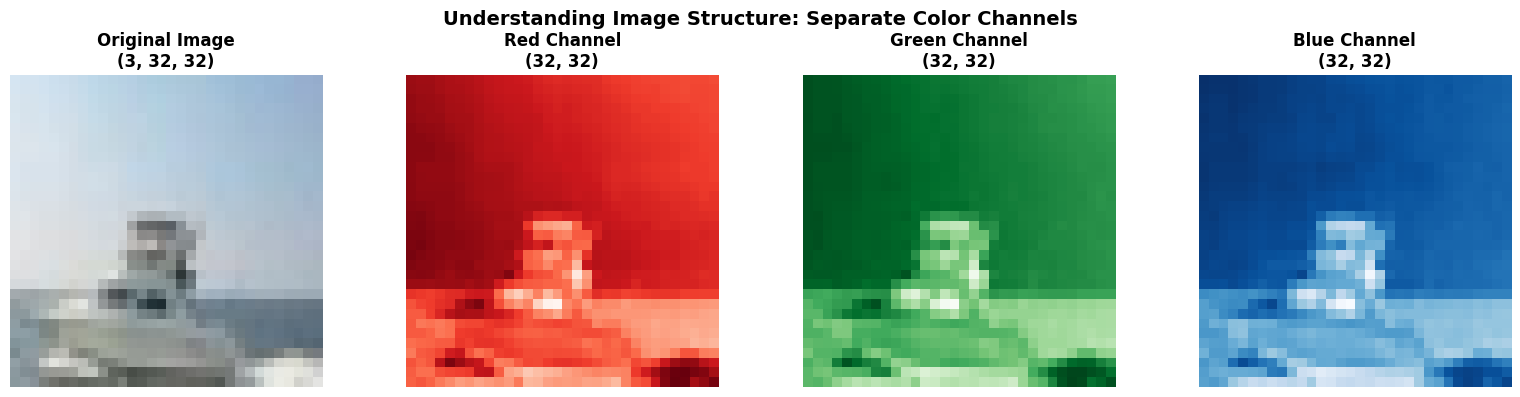

In [10]:
# Visualize RGB channels
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

img, label = train_dataset[100]
img_display = img * 0.5 + 0.5
img_display = img_display.permute(1, 2, 0).numpy()
img_display = np.clip(img_display, 0, 1)

axes[0].imshow(img_display)
axes[0].set_title('Original Image\n(3, 32, 32)', fontweight='bold')
axes[0].axis('off')

for i, (channel_name, color) in enumerate([('Red', 'Reds'), ('Green', 'Greens'), ('Blue', 'Blues')]):
    axes[i+1].imshow(img[i].numpy(), cmap=color)
    axes[i+1].set_title(f'{channel_name} Channel\n(32, 32)', fontweight='bold')
    axes[i+1].axis('off')

plt.suptitle('Understanding Image Structure: Separate Color Channels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

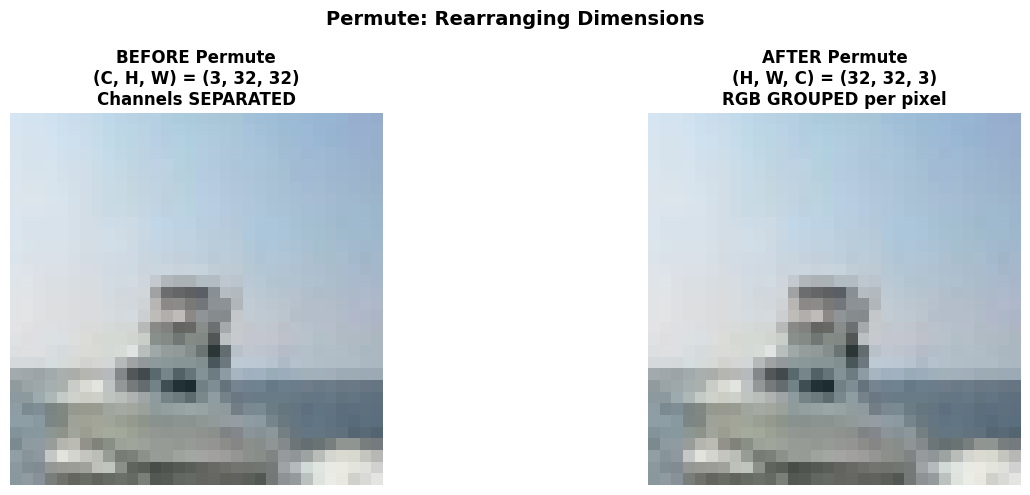


💡 The images look the same, but the data layout is different!
   BEFORE: img[channel, row, col] - channels separated
   AFTER:  img[row, col, channel] - RGB values together


In [11]:
# Visualize permute effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

img_permuted = img.permute(1, 2, 0)

axes[0].imshow(img_display)
axes[0].set_title('BEFORE Permute\n(C, H, W) = (3, 32, 32)\nChannels SEPARATED', 
                   fontweight='bold', fontsize=12)
axes[0].axis('off')

axes[1].imshow(img_permuted.numpy() * 0.5 + 0.5)
axes[1].set_title('AFTER Permute\n(H, W, C) = (32, 32, 3)\nRGB GROUPED per pixel', 
                   fontweight='bold', fontsize=12)
axes[1].axis('off')

plt.suptitle('Permute: Rearranging Dimensions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 The images look the same, but the data layout is different!")
print("   BEFORE: img[channel, row, col] - channels separated")
print("   AFTER:  img[row, col, channel] - RGB values together")

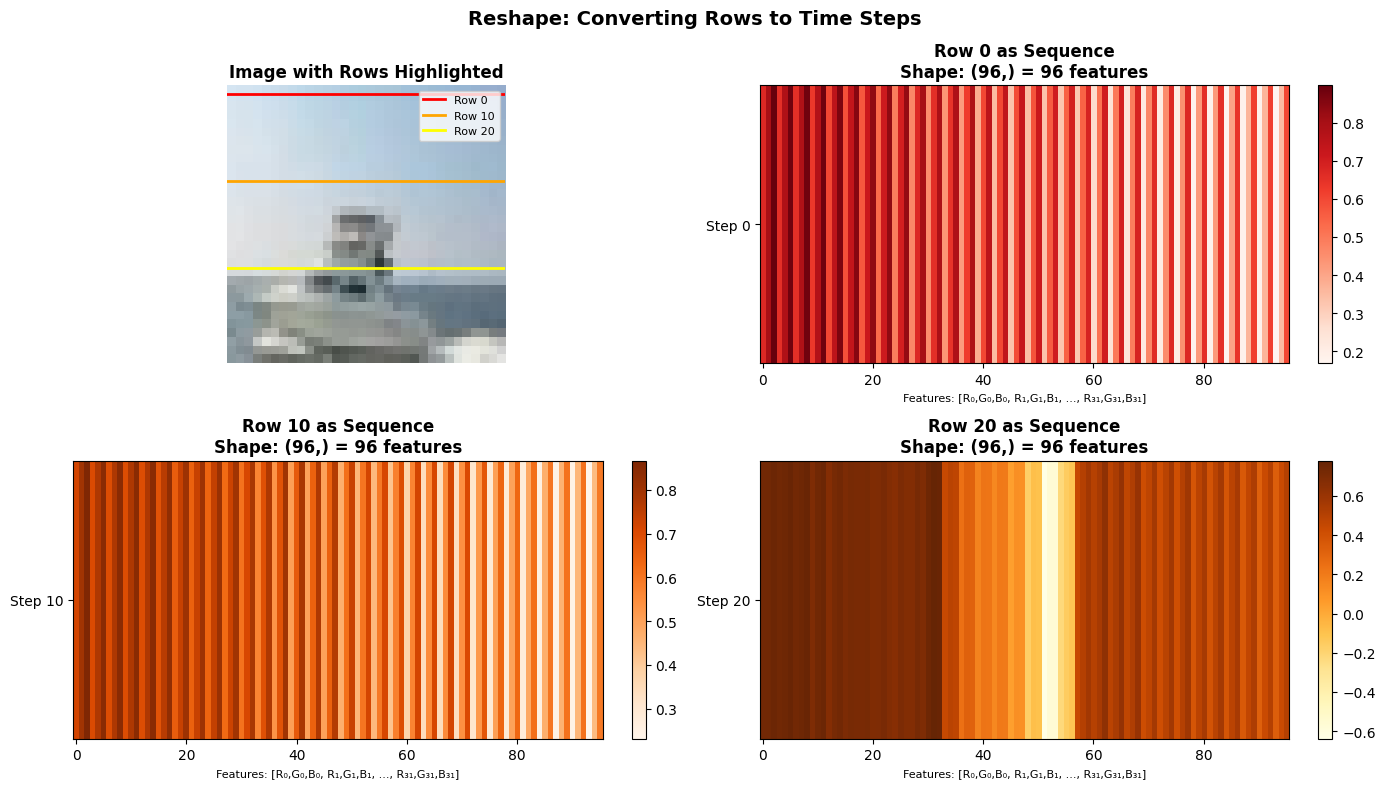


💡 Each highlighted row becomes ONE time step in the sequence!


In [12]:
# Visualize rows as sequences
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].imshow(img_display)
axes[0, 0].set_title('Image with Rows Highlighted', fontweight='bold')
axes[0, 0].axhline(y=0.5, color='red', linewidth=2, label='Row 0')
axes[0, 0].axhline(y=10.5, color='orange', linewidth=2, label='Row 10')
axes[0, 0].axhline(y=20.5, color='yellow', linewidth=2, label='Row 20')
axes[0, 0].legend(loc='upper right', fontsize=8)
axes[0, 0].axis('off')

img_seq = img_permuted.reshape(32, 96)

for i, (row_num, color) in enumerate([(0, 'Reds'), (10, 'Oranges'), (20, 'YlOrBr')]):
    ax_idx = [(0, 1), (1, 0), (1, 1)][i]
    ax = axes[ax_idx]
    
    row_data = img_seq[row_num].numpy().reshape(1, -1)
    im = ax.imshow(row_data, cmap=color, aspect='auto')
    ax.set_title(f'Row {row_num} as Sequence\nShape: (96,) = 96 features', fontweight='bold')
    ax.set_xlabel('Features: [R₀,G₀,B₀, R₁,G₁,B₁, ..., R₃₁,G₃₁,B₃₁]', fontsize=8)
    ax.set_yticks([0])
    ax.set_yticklabels([f'Step {row_num}'])
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Reshape: Converting Rows to Time Steps', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Each highlighted row becomes ONE time step in the sequence!")

---

<a id='summary'></a>
# Part 5: Summary & Best Practices

## Comparison Table

| Data Type | Original Format | Final Format | Transformation Needed |
|-----------|----------------|--------------|----------------------|
| **Text** | String | `(seq_len, 1, vocab_size)` | One-hot encoding only |
| **Images** | `(C, H, W)` | `(H, C×W)` | Permute + Reshape |
| **Time Series** | `(features,)` per time | `(time_steps, features)` | Stack time steps |
| **Audio** | `(samples,)` | `(frames, frame_features)` | STFT + Window |

## Key Principles

### 1. **Always check shapes before and after**
```python
print(f"Before: {data.shape}")
data_transformed = transform(data)
print(f"After: {data_transformed.shape}")
```

### 2. **Maintain data integrity**
- Permute **before** reshape for images
- Keep related features together (RGB per pixel)
- Preserve temporal order

### 3. **Batch dimension first**
```python
# Good: (batch, seq_len, features)
# Bad:  (seq_len, batch, features)  # unless using batch_first=False
```

### 4. **Consistent preprocessing**
- Apply **same** transformations to train and test data
- Document your preprocessing steps
- Save preprocessing parameters

## Common Mistakes to Avoid

❌ **Skipping permute for images**
```python
# Wrong
img.reshape(32, 96)  # RGB values get scrambled!
```

✅ **Correct approach**
```python
# Right
img.permute(1, 2, 0).reshape(32, 96)  # RGB stays together
```

❌ **Inconsistent shapes**
```python
# Wrong
train_data = preprocess_train(data)  # (batch, seq, feat)
test_data = preprocess_test(data)    # (seq, batch, feat) - Different!
```

✅ **Consistent preprocessing**
```python
# Right
def preprocess(data):
    return data.reshape(-1, seq_len, features)  # Same for all
```

## Quick Reference

### Text → Sequence
```python
text = "Albert"
tensor = lineToTensor(text)  # (6, 1, 58)
# Ready for RNN!
```

### Image → Sequence
```python
image = load_image()  # (3, 32, 32)
image = image.permute(1, 2, 0)  # (32, 32, 3)
sequence = image.reshape(32, 96)  # (32, 96)
# Ready for RNN!
```

### Batch → Sequences
```python
batch = load_batch()  # (64, 3, 32, 32)
batch = batch.permute(0, 2, 3, 1)  # (64, 32, 32, 3)
sequences = batch.reshape(-1, 32, 96)  # (64, 32, 96)
# Ready for RNN!
```

## Next Steps

Now that you understand data preprocessing for RNNs:

1. **Practice** with different data types
2. **Experiment** with different sequence lengths
3. **Check** the companion notebook: `RNN_Methods_Comparison.ipynb`
4. **Build** your own RNN models!

---

## Additional Resources

- PyTorch Documentation: [torch.Tensor.permute](https://pytorch.org/docs/stable/generated/torch.Tensor.permute.html)
- PyTorch Documentation: [torch.Tensor.reshape](https://pytorch.org/docs/stable/generated/torch.Tensor.reshape.html)
- Understanding RNN Input Shapes: [PyTorch RNN Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)